<a href="https://colab.research.google.com/github/Kienknu/Kienknu/blob/main/Copy_of_K_SOA_Isoprene_0610_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Isoprene


In [ ]:
!pip install rdkit
!pip install molmass

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 1.9 MB/s eta 0:00:00


In [ ]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdChemReactions
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import display
from rdkit.Chem import Descriptors
import pandas as pd
import requests
import io
from molmass import Formula
import matplotlib.pyplot as plt
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors

# 1. Necessary functions

In [ ]:
def cluster_and_filter(mols, cutoff):
    # 1. Calculate Fingerprints for current molecules
    fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in mols]

    # 2. Calculate distances iteratively
    num_mols = len(mols)
    dists = []
    for i in range(1, num_mols):
        sims = rdkit.DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
        dists.extend([1 - x for x in sims])  # Convert similarity to distance

    cs = Butina.ClusterData(dists, num_mols, cutoff, isDistData=True)
    unique_mols = [mols[c[0]] for c in cs]
    return unique_mols

# Mass calculation from data
def calculate_monoisotopic_masses(formula):
    try:
        f = Formula(formula)
        mono_mass = f.isotope.mass  # Monoisotopic mass
        mh_mass = mono_mass - 1.007825  # [M-H]
        mph_mass = mono_mass + 1.007825  # [M+H]
        return mono_mass, mh_mass, mph_mass
    except Exception as e:
        print(f"Error with formula {formula}: {e}")
        return None, None, None

# Trace reaction Function
def trace_reaction_path(target_product_smiles, reaction_history_1):
    """Traces the reaction pathway through reaction_history_1"""

    reaction_path = []
    current_product = target_product_smiles

    # Search in reaction_history_1
    while current_product:
        found_in_history = False
        for i in range(len(reaction_history_1) - 1, -1, -1):
            if reaction_history_1[i][2] == current_product:
                reaction_path.insert(0, reaction_history_1[i])
                current_product = reaction_history_1[i][0]
                found_in_history = True
                break

        if not found_in_history:
            current_product = None

    return reaction_path

# 2. Experimental data with mass calculation

In [ ]:
# online file
url = "https://docs.google.com/spreadsheets/d/1pBx8tnFjT5FHe-KaPjAOxNMYgYAr6ie-/edit?usp=sharing&ouid=105784435570061437896&rtpof=true&sd=true"

# spreadsheet ID
spreadsheet_id = url.split("/d/")[1].split("/")[0]

# Excel export URL
excel_export_url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=xlsx"

# Download
response = requests.get(excel_export_url)
response.raise_for_status()

# Read
exp_data = pd.read_excel(io.BytesIO(response.content), sheet_name='ISO_NH3_CHON', engine='openpyxl')

# Add new column for Monoisotopic mass:
exp_data[['Neutral_Mass', '[M-H]', '[M+H]']] = exp_data['Formula'].apply(
    lambda x: pd.Series(calculate_monoisotopic_masses(x))
)

exp_data.head()

,Class,DBE,Neutral_DBE,Formula,Exp_m/z,Neutral_mass,Mono_Abund,Total_Abund,Calc_m/z,#C,...,#N,#O,#S,H/C,N/C,O/C,S/C,Neutral_Mass,[M-H],[M+H]
0,NO,3.5,3,C3H3NO,68.014280,69.021556,20364.30,20364.30,68.014187,3,...,1,1,0,1.0000,0.3333,0.3333,0,69.021464,68.013639,70.029289
1,N2O,3.5,3,C2H2N2O,69.009509,70.016785,56457.17,56457.17,69.009436,2,...,2,1,0,1.0000,1.0000,0.5000,0,70.016713,69.008888,71.024538
2,NO,1.5,1,C3H7NO,72.045571,73.052847,133767.85,133928.43,72.045487,3,...,1,1,0,2.3333,0.3333,0.3333,0,73.052764,72.044939,74.060589
3,NO,3.5,3,C4H5NO,82.029900,83.037176,45922.97,45922.97,82.029837,4,...,1,1,0,1.2500,0.2500,0.2500,0,83.037114,82.029289,84.044939
4,N2O,3.5,3,C3H4N2O,83.025136,84.032412,4041310.24,4145474.81,83.025086,3,...,2,1,0,1.3333,0.6667,0.3333,0,84.032363,83.024538,85.040188


#3. Simulation

In [ ]:
reaction_rules_1 = [

        #-----Nitration: NO₂ group addition----#
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][N+](=O)[O-]'),       #      n=3>>0.14%)
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][N+](=O)[O-]'),         #      n=3>>0.28%(selected)+
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][N+](=O)[O-]'),          #    n=3>>0.28%
    AllChem.ReactionFromSmarts('[CH:1]>>[C:1][N+](=O)[O-]'),          #       n=3>>0.14%(selected)

        #-----Nitrosation: NO group addition----#
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][N](=O)'),            #      n=3>>0%
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][N](=O)'),              #      n=3>>0.28%(selected)+
    AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][N](=O)'),               #     n=3>>0.14%(selected)+
    AllChem.ReactionFromSmarts('[CH:1]>>[C:1][N](=O)'),               #       n=3>>2.13%(selected)

        #-----Carboxylation: COOH group addition----#
    #AllChem.ReactionFromSmarts('[CH3:1]>>[C:1]C(=O)O'),               #      n=3>>3.4%
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(=O)O'),               #      n=3>>5.53%(selected)+
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1]C(=O)O'),               #      n=3>>5.67%
    AllChem.ReactionFromSmarts('[CH:1]>>[C:1]C(=O)O'),                 #      n=3>>5.67%(selected)+

        #-----Carbonylation: CO group addition----#
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(=O)'),               #      n=3>>5.67%
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1]C(=O)'),              #      n=3>>5.67%
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1]C(=O)'),                #      n=3>>5.7%
    #AllChem.ReactionFromSmarts('[CH:1]>>[C:1]C(=O)'),                 #      n=3>>5.7%

        #-----Carbon Coupling----#
    AllChem.ReactionFromSmarts('[C:1][*:2]>>[C:1][C:2]'),              #      n=3>>6.1%(selected)+

        #-----Hydroperoxide Formation----#
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1]OO'),                  #      n=3>>7.09%
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1]OO'),                   #      n=3>>7.09%
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]OO'),                   #      n=3>>7.09%(selected)+
    #AllChem.ReactionFromSmarts('[CH3:1][*]>>[CH2:1]OO'),              #      n=1>>1.87%

        #-----Amination: NH2 addition----#
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][NH2]'),                #      n=3>>7.66%(selected)+
    AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][NH2]'),               #      n=3>>8.23%(selected)+
    #AllChem.ReactionFromSmarts('[CH:1]>>[C:1][NH2]'),                 #      n=3>>8.23%
    AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][NH2]'),                 #      n=3>>8.51%(selected)+

        #-----Hydroxylation: OH addition----#
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][OH]'),                #      n=3>>8.51%
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][OH]'),               #      n=3>>8.79%
    AllChem.ReactionFromSmarts('[CH:1]>>[C:1][OH]'),                   #      n=3>>8.79%(selected)+
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][OH]'),                #      n=3>>8.51%

        #-----Radical Generation----#
    #AllChem.ReactionFromSmarts('[CH:1]>>[C:1][*]'),                   #      n=3>>10.07%
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][*]'),                #      n=3>>10.07%
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][*]'),                 #      n=3>>10.07%
    AllChem.ReactionFromSmarts('[CH:1]>>[C:1][*]'),                    #      n=3>>10.07% (selected)

        #-----Alkene Oxidation/Dihydroxylation----#
    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1](O)-[C:2]'),        #      n=3>>10.78%
    AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1](O)-[C:2](O)'),      #      n=3>>10.92% (selected)+

        #-----Carbon Chain Branching----#
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(C)'),                # (2)  n=3>>14.89%-
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(C)[C:2]'),         #      n=3>>14.89%-
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(=C)'),               #      n=3>>14.89%-
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(=C)[C:2]'),        #      n=3>>14.89%-

    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(C)C'),               # (3)  n=3>>14.89-
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(C)C[C:2]'),         #     n=3>>15.18%(selected)+
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(=C)C'),              #      n=3>>15.18%-
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(=C)C[C:2]'),        #     n=3>>15.89%(selected)+

    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(C)C(C)'),            # (4)  n=3>>15.89%-
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(C)C(C)[C:2]'),     #      n=3>>15.89%-
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(=C)C(=C)'),          #      n=3>>17.02%-
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(=C)C(=C)[C:2]'),    #     n=3>>17.30%(selected)+

    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(C)C(C)C'),           # (5)  n=3>>17.30%-
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(C)C(C)C[C:2]'),     #     n=3>>17.59%(selected)+
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(=C)C(=C)C'),         #      n=3>>17.59%-
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(=C)C(=C)C[C:2]'),   #     n=3>>18.01%(selected)+

        # Dehydration/dehydroxylation
    #AllChem.ReactionFromSmarts('[C:1](O)[CH3]>>[C:1]=[CH2]'),            # n=3>>10.92%-
    #AllChem.ReactionFromSmarts('[C:1](O)C>>[C:1]'),                      # 14.Dehydration                n=3>>10.92%-

        # Oxidation/amidation
    #AllChem.ReactionFromSmarts('[CH:1](=O)>>[C:1](=O)[OH]'),             #                               n=3>>10.92%-
    #AllChem.ReactionFromSmarts('[CH:1](=O)>>[C:1](=O)[O]'),              #     n=3>>10.92%-
    #AllChem.ReactionFromSmarts('[CH:1](=O)[OH]>>[C:1](=O)[NH2]'),        #     n=3>>10.92%-
    #AllChem.ReactionFromSmarts('[C:1](=O)[OH]>>[C:1](=O)[NH2]'),         #     n=3>>10.92%-
    #AllChem.ReactionFromSmarts('[C:1](=O)[O:2]>>[C:1](=O)[N:2]'),        #     n=3>>10.92%-
    #AllChem.ReactionFromSmarts('[C:1](=[O:2])[H]>>[C:1](=[O:2])[OH]'),   #     n=3>>10.92%-


        #-----Epoxidation / Internal Rearrangement----#
    AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1]OC[C:2]'),              #     n=3>>11.06%(selected)+
    AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1]C(=O)C[C:2]'),          #     n=3>>11.77%(selected)+

        #-----Oligomerization----#
    AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1][CH]=[CH][C:2]'),        #     n=3>>12.77%(selected)+

       # Addition of NO/NO₂ to alkene
    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1][NO2]-[C:2]'),         #     n=3>>12.77%-
    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1][NO]-[C:2]'),          #     n=3>>12.77%

       # Ozonolysis of Alkenes
    #AllChem.ReactionFromSmarts('[CH2:1]=[CH2:2]>>[C:1](=O)[OH].[C:2](=O)'),    # n=3>>12.77%-
    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1](=O).[C:2](=O)'),            # n=3>>12.77%-

        # Epoxide Hydrolysis to Vicinal Diols
    #AllChem.ReactionFromSmarts('[C:1]1OC1[C:2]>>[C:1][OH][CH2:2][OH]'),        # n=3>>12.77%-

        # Radical formation
    #AllChem.ReactionFromSmarts('[OH:1]>>[O:1][*]'),                      # n=3>>12.77%-
    #AllChem.ReactionFromSmarts('[OOH:1]>>[OO:1][*]'),                    # n=3>>12.77%-
    #AllChem.ReactionFromSmarts('[OO:1][*]>>[O:1][*]'),                   # n=3>>12.77%-
    #AllChem.ReactionFromSmarts('[O:1][OH:2]>>[O:1][O:2][*]'),            # n=3>>12.77%-

        # Nitrate ester formation
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][ONO2]'),                 # n=3>>12.77%-
    #AllChem.ReactionFromSmarts('[O:1][O:2][*]>>[O:1][N+:2](=O)[O-]'),    # n=3>>12.77%-
    #AllChem.ReactionFromSmarts('[O:1][O][*]>>[O:1][N+](=O)[O-]'),        # n=3>>12.77%-
    #AllChem.ReactionFromSmarts('[O:1][*]>>[O:1][N+](=O)[O-]'),           # n=3>>12.77%-

    #AllChem.ReactionFromSmarts('[O:1][O][*]>>[O:1][N]=O'),               # n=3>>12.77%-
    #AllChem.ReactionFromSmarts('[O:1][*]>>[O:1][N]=O'),                  # n=3>>12.77%-

        # Oxidation of Alcohol to carbonyl
    #AllChem.ReactionFromSmarts('[CH:1][OH]>>[C:1]=O'),                   # n=3>>12.77%-
    #AllChem.ReactionFromSmarts('[C:1](C[OH])>>[C:1](C=O)'),              # n=3>>12.77%-

        # Aldehyde to carboxylic acid
    #AllChem.ReactionFromSmarts('[C:1](C=O)>>[C:1](C(=O)O)'),             # n=3>>12.77%-
        # Peroxy acid to carboxylic acid
    #AllChem.ReactionFromSmarts('[C:1](=O)OO>>[C:1](=O)O'),               # n=3>>12.77%-
        # Alcohol to amine
    #AllChem.ReactionFromSmarts('[C:1](O)>>[C:1][NH2]'),                  # n=3>>12.77%-

        # Peroxynitrite formation
    #AllChem.ReactionFromSmarts('[C:1]OO>>[C:1]O[N]=O'),                  # n=3>>12.77%-
    #AllChem.ReactionFromSmarts('[C:1][O:2][O]>>[C:1][O:2][N]=O'),        # n=3>>12.77%-
    #AllChem.ReactionFromSmarts('[C:1][O:2][O][*]>>[C:1][O:2][N]=O'),     # n=3>>12.77%-
    #AllChem.ReactionFromSmarts('[C:1]OO>>[C:1]O[N+](=O)[O-]'),           # n=3>>12.77%-

        # Hydroperoxide to alcohol(OOH to OH)
    #AllChem.ReactionFromSmarts('[C:1][O][O]>>[C:1][O]'),                 # n=3>>12.77%-
        # ROO• to to carbonyl
    #AllChem.ReactionFromSmarts('[C:1]OO>>[C:1]O'),                       # n=3>>12.77%-
        # ROO• to peracid
    #AllChem.ReactionFromSmarts('[C:1]OO>>[C:1]O[O]'),                    # n=3>>12.77%-

    #Carboxylic acid to amide/Ammonolysis/Oxime-like formation
    #AllChem.ReactionFromSmarts('[C:1](=O)O>>[C:1](=O)[NH2]'),            # n=3>>12.77%-
    #AllChem.ReactionFromSmarts('[C:1]C(=O)[O-]>>[C:1]C(=O)[NH2]'),       # n=3>>12.77%-
    #AllChem.ReactionFromSmarts('[C:1]=O>>[C:1]=N[O]'),                   # n=3>>12.77%-

    #AllChem.ReactionFromSmarts('[C:1](=O)[CH3]>>[C:1]=N'),               #n=3>>12.77%-
    #AllChem.ReactionFromSmarts('[C:1](=O)O[*]>>[C:1](=O)[NH2]'),         #n=3>>12.77%-
    #AllChem.ReactionFromSmarts('[*:1][*]>>[*:1][NH2]'),                  #n=3>>12.77%-

    #-----Nitrate ester formation----#
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][O][N+](=O)[O-]'),       #n=3>>14.47%
    AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][O][N+](=O)[O-]'),         #n=3>>14.61%(selected)+
    #AllChem.ReactionFromSmarts('[CH:1][*]>>[C:1][O][N+](=O)[O-]'),       #n=3>>14.89%
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][O][N+](=O)[O-]'),         #n=3>>14.89%(selected)+

    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][O][N](=O)'),            #n=3>>14.89%
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][O][N](=O)'),             #n=3>>14.89%
    #AllChem.ReactionFromSmarts('[CH:1][*]>>[C:1][O][N](=O)'),            #n=3>>14.89%
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][O][N](=O)'),             #n=3>>14.89%

    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1]([OH])[C:2][*]'),      # OH addition #n=3>>14.89%
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]O[O*]'),                  # O2 addition #n=3>>14.89%
    #AllChem.ReactionFromSmarts('[C:1]O[O*]>> [C:1]O'),                   # NO reaction #n=3>>14.89%

    # FROM CMC Web
    ##AllChem.ReactionFromSmarts('C=CC(=C)C>>C/C(=C/[CH2])/CO'),    #C5H8>>CISOPA
    ##AllChem.ReactionFromSmarts('C=CC(=C)C>>C/C(=C\[CH2])/CO'),    #C5H8>>TISOPA
    ##AllChem.ReactionFromSmarts('C=CC(=C)C>>OC/C=C(\[CH2])/C'),    #C5H8>>CISOPC
    ##AllChem.ReactionFromSmarts('C=CC(=C)C>>OC/C=C(\C)/[CH2]'),    #C5H8>>TISOPC
    #AllChem.ReactionFromSmarts('C=CC(=C)C>>CC(=O)CC=C'),          #C5H8>>PE4E2CO
    #AllChem.ReactionFromSmarts('C=CC(=C)C>>CC(=C)CC=O'),          #C5H8>>ME3BU3ECHO
    #AllChem.ReactionFromSmarts('C=CC(=C)C>>CC(=C)C(CO[O])O'),     #C5H8>>ISOP34O2

    ##AllChem.ReactionFromSmarts('C/C(=C/[CH2])/CO>>OCC(C)(O[O])C=C'),  #CISOPA>>ISOPBO2
    ##AllChem.ReactionFromSmarts('C/C(=C/[CH2])/CO>>[O]OC/C=C(\CO)/C'), #CISOPA>>CISOPAO2

    ##AllChem.ReactionFromSmarts('OC/C=C(\[CH2])/C>>OCC(O[O])C(=C)C'),  #CISOPC>>ISOPDO2
    ##AllChem.ReactionFromSmarts('OC/C=C(\[CH2])/C>>[O]OC/C(=C\CO)/C'), #CISOPC>>CIOPCO2

    #AllChem.ReactionFromSmarts('CC(=O)CC=C>>CC(=O)O[O].[O]OCC=C'),    #PE4E2CO>>CH3CO3.CH2CHCH2O2
    #AllChem.ReactionFromSmarts('CC(=O)CC=C>>OCC(O[O])CC(=O)C'),       #PE4E2CO>>C51O2


]

In [ ]:
###--------Simulation part---------###
chemical_space_1 = {'C=CC(=C)C'}
num_iterations_1 = 3

# Comparison conditions
tolerance = 0.0000001  # 0.1ppm
matching_excel_info = []

excel_mw_neg = exp_data['[M-H]'].tolist()
excel_mw_neu = exp_data['Neutral_Mass'].tolist()
excel_mw_pos = exp_data['[M+H]'].tolist()

# Initial conditions
max_mass = exp_data['[M+H]'].max()
max_carbons = exp_data['#C'].max()
max_nitrogens = exp_data['#N'].max()
max_oxygens = exp_data['#O'].max()

# Reaction for chemical_space_1
reaction_history_1 = []
all_matching_smiles = set()
clustering_frequency = 3

for iteration in range(num_iterations_1):
    temp_new_products = set()
    for reactant_smiles in chemical_space_1.copy():
        reactant_mol = Chem.MolFromSmiles(reactant_smiles)
        if reactant_mol:

            # Apply reaction rules
            for rxn_index, rxn in enumerate(reaction_rules_1):
                possible_products = rxn.RunReactants((reactant_mol,))
                for prod_set in possible_products:
                    for prod in prod_set:
                        try:
                            Chem.SanitizeMol(prod, Chem.SanitizeFlags.SANITIZE_ALL)
                            Chem.AssignStereochemistry(prod, force=True, cleanIt=True)

                            prod_smiles = Chem.MolToSmiles(prod)
                            prod_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles), canonical=True)

                            # Valence check
                            prod_mol = Chem.MolFromSmiles(prod_smiles,sanitize=False)
                            if prod_mol.GetNumAtoms() > 0:
                              try:
                                Chem.rdmolops.SanitizeMol(prod_mol, Chem.rdmolops.SanitizeFlags.SANITIZE_ALL)
                              except:
                                pass

                              if len(Chem.DetectChemistryProblems(prod_mol)) == 0:

                                # Check and add to temp_new_products and reaction_history
                                if prod_smiles not in chemical_space_1:
                                    temp_new_products.add(prod_smiles)
                                    # Check if the product is a match and update is_match
                                    is_match = False

                                    # Check within the inner loop
                                    calculated_mw_temp = Descriptors.ExactMolWt(prod_mol)
                                    for excel_mw_list, excel_column in zip(
                                    [excel_mw_neg, excel_mw_neu, excel_mw_pos], ['[M-H]', 'Neutral_Mass', '[M+H]']):
                                        for excel_mw_value in excel_mw_list:
                                            diff = abs(calculated_mw_temp - excel_mw_value)
                                            if diff <= tolerance:
                                                is_match = True
                                                all_matching_smiles.add(prod_smiles)
                                                break
                                        if is_match:
                                            break

                                    reaction_history_1.append((reactant_smiles, rxn_index, prod_smiles, prod_smiles in all_matching_smiles))

                        except:
                            pass

    chemical_space_1.update(temp_new_products)
    ###----------Periodic clustering and filtering-------###
    #if (iteration + 1) % clustering_frequency == 0:
        #temp_mols = [Chem.MolFromSmiles(smi) for smi in chemical_space_1]
        #fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in temp_mols]
        #unique_products = cluster_and_filter(temp_mols, cutoff=0.6)
        #chemical_space_1 = set([Chem.MolToSmiles(mol) for mol in unique_products])
    ##########################################################

# Apply threshold
chemical_space_1 = {smi for smi in chemical_space_1
                           if Descriptors.ExactMolWt(Chem.MolFromSmiles(smi)) <= max_mass
                           and sum(1 for atom in Chem.MolFromSmiles(smi).GetAtoms() if rdkit.Chem.rdchem.GetPeriodicTable().GetAtomicNumber(atom.GetSymbol()) == 6) <= max_carbons
                           and sum(1 for atom in Chem.MolFromSmiles(smi).GetAtoms() if rdkit.Chem.rdchem.GetPeriodicTable().GetAtomicNumber(atom.GetSymbol()) == 7) <= max_nitrogens
                           and sum(1 for atom in Chem.MolFromSmiles(smi).GetAtoms() if rdkit.Chem.rdchem.GetPeriodicTable().GetAtomicNumber(atom.GetSymbol()) == 8) <= max_oxygens}

# Create mols_1 and valid_smiles_1 from chemical_space_1
mols_1 = [Chem.MolFromSmiles(smi) for smi in chemical_space_1]
valid_smiles_1 = list(chemical_space_1)

In [ ]:
print(len(chemical_space_1))

15182


**Matching Comparison**

In [ ]:
# Mass calculation and comparison for mols_1

calculated_mw_1 = []
for mol in mols_1:
  mw = Chem.Descriptors.ExactMolWt(mol)
  calculated_mw_1.append(mw)

for i, calculated_mw_value in enumerate(calculated_mw_1):
    for excel_mw_list, excel_column in zip(
        [excel_mw_neg, excel_mw_neu, excel_mw_pos], ['[M-H]', 'Neutral_Mass', '[M+H]']
    ):
        for j, excel_mw_value in enumerate(excel_mw_list):
            diff = abs(calculated_mw_value - excel_mw_value)

            if diff <= tolerance and valid_smiles_1[i] not in all_matching_smiles:
                #matching_smiles_1.append(valid_smiles_1[i])
                all_matching_smiles.add(valid_smiles_1[i])

                # Check if the product is match
                is_match = True
            else:
                is_match = False

            reaction_history_1.append((reactant_smiles, rxn_index,prod_smiles, is_match))

            break

# Find matching indices based on all_matching_smiles
matching_excel_info_all = []
for smi in all_matching_smiles:
  calculated_mw_value = Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(smi))
  for excel_mw_list, excel_column in zip(
      [excel_mw_neg, excel_mw_neu, excel_mw_pos], ['[M-H]', 'Neutral_Mass', '[M+H]']
  ):
    for j, excel_mw_value in enumerate(excel_mw_list):
      diff = abs(calculated_mw_value - excel_mw_value)

      if diff <= tolerance:
        row_index = exp_data.index[exp_data[excel_column] == excel_mw_value].tolist()[0]
        matching_excel_info_all.append((row_index))
        break

# Get all row in the Excel file
all_excel_indices = set(exp_data.index)

matching_indices_set = set(matching_excel_info_all)
matching_percentage = (len(matching_indices_set) / len(all_excel_indices)) * 100

print(f"Matching percentage: {matching_percentage:.2f}%")

Matching percentage: 15.18%


In [ ]:
"""
### Display molecules in matching_smiles if needed###

matching_mols= [Chem.MolFromSmiles(smi) for smi in all_matching_smiles]
valid_smiles = list(all_matching_smiles)

max_mols_to_draw = len(matching_mols)
mols_to_draw = matching_mols[:min(len(matching_mols), max_mols_to_draw)]
legends_to_draw = valid_smiles[:min(len(valid_smiles), max_mols_to_draw)]


img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=4, subImgSize=(100, 100),
                             legends=legends_to_draw,
                             maxMols=len(mols_to_draw),useSVG=True)
display(img)
"""

#4. Pathways

Reaction pathway for CCC(=O)C=CCN=O:


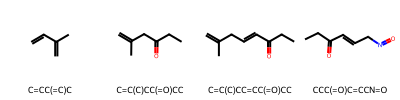

--------------------
Reaction pathway for C=C(O)C(C)CC(=O)N=O:


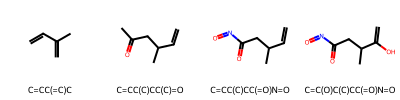

--------------------
Reaction pathway for CC(=CN=O)C(=O)O[N+](=O)[O-]:


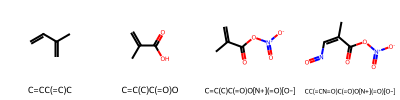

--------------------
Reaction pathway for C=CC=CC(=C)O[N+](=O)[O-]:


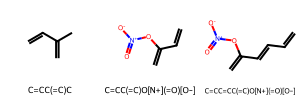

--------------------
Reaction pathway for C=CC(CC(=O)[N+](=O)[O-])[N+](=O)[O-]:


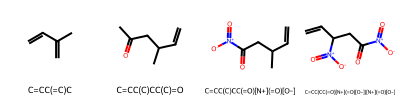

--------------------
Reaction pathway for C=C(C=CO[N+](=O)[O-])C(O)C(C)O:


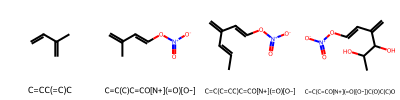

--------------------
Reaction pathway for CC(C=CN=O)C(=O)OO:


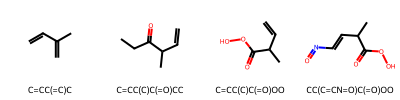

--------------------
Reaction pathway for C=C(C=CC=O)O[N+](=O)[O-]:


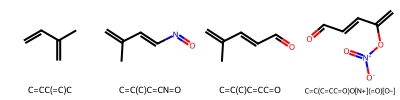

--------------------
Reaction pathway for C=C(C)CC(O[N+](=O)[O-])C(=O)O[N+](=O)[O-]:


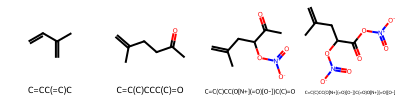

--------------------
Reaction pathway for C=C(C)C(CO)C(=O)N=O:


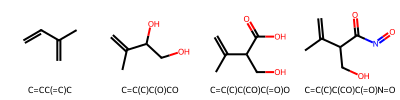

--------------------
Reaction pathway for C=CC(C(=O)O)C(=O)CN:


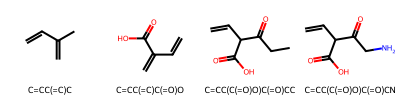

--------------------
Reaction pathway for C=CC(C)=CC(=O)[N+](=O)[O-]:


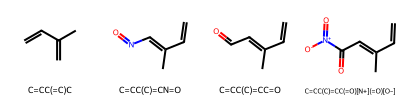

--------------------
Reaction pathway for C=C(N=O)C(O)N=O:


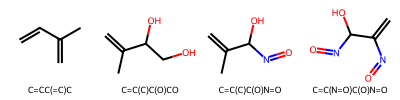

--------------------
Reaction pathway for C=C(C)C(OC(C)O[N+](=O)[O-])O[N+](=O)[O-]:


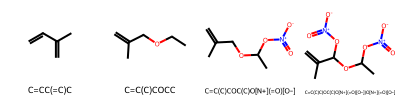

--------------------
Reaction pathway for C=C(C)C=C(N=O)C(=O)N=O:


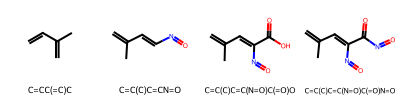

--------------------
Reaction pathway for C=CC(=C)C=C(N)C(=O)O:


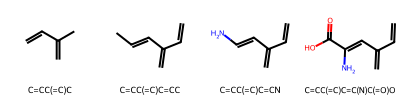

--------------------
Reaction pathway for C=C(C(=O)O)C(C)(O)C(O)O[N+](=O)[O-]:


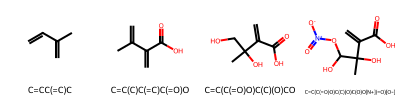

--------------------
Reaction pathway for C=CC(C(=O)O)=C(N)[N+](=O)[O-]:


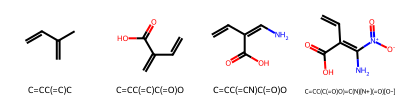

--------------------
Reaction pathway for *C(=CC(C)=CN=O)N=O:


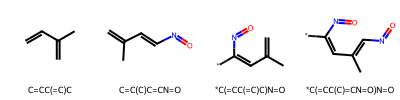

--------------------
Reaction pathway for C=C(CCC(=O)CO[N+](=O)[O-])C(=O)O:


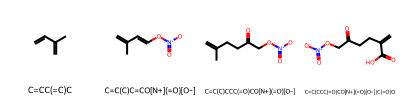

--------------------
Reaction pathway for C=CC(=C)C=C(N=O)N=O:


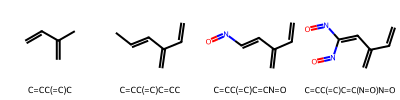

--------------------
Reaction pathway for C=C(C=CN)C(=C)[N+](=O)[O-]:


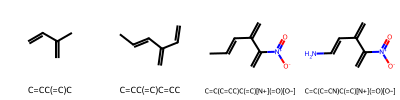

--------------------
Reaction pathway for *C(COC)C(=C)O[N+](=O)[O-]:


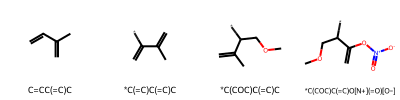

--------------------
Reaction pathway for C=CC(C)=CC[N+](=O)[O-]:


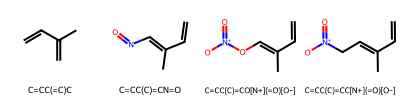

--------------------
Reaction pathway for C=CC(N=O)C(=O)C(C)O[N+](=O)[O-]:


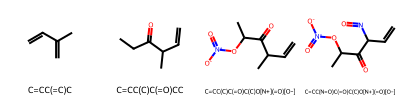

--------------------
Reaction pathway for C=C(O)C(C)C(=O)CN=O:


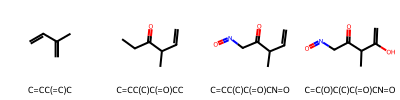

--------------------
Reaction pathway for *C(=CN)N=O:


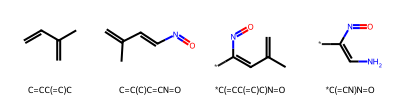

--------------------
Reaction pathway for CC(=O)C=C[N+](=O)[O-]:


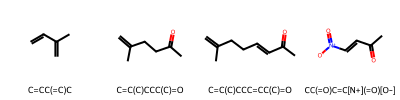

--------------------
Reaction pathway for C=CC=CC(C)=C(O)O[N+](=O)[O-]:


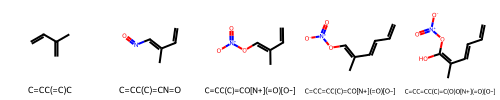

--------------------
Reaction pathway for *C(CO)(O[N+](=O)[O-])C(=C)C:


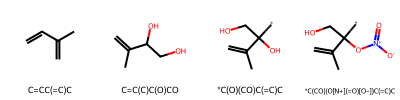

--------------------
Reaction pathway for C=C(C)C(C(=O)C[N+](=O)[O-])[N+](=O)[O-]:


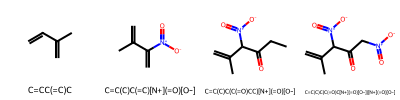

--------------------
Reaction pathway for O=NC(O)=CC(=O)O:


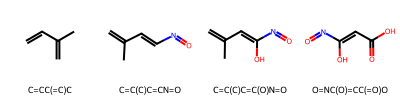

--------------------
Reaction pathway for C=CC(=C)C(O)=C(C)[N+](=O)[O-]:


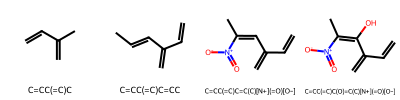

--------------------
Reaction pathway for C=CC(=C)C(=CN=O)[N+](=O)[O-]:


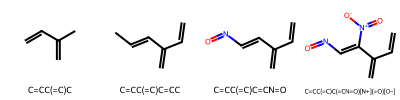

--------------------
Reaction pathway for *C(C)=CC(=C)C=CO[N+](=O)[O-]:


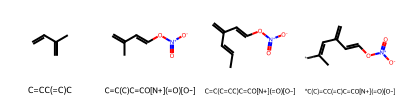

--------------------
Reaction pathway for C=C(COCN=O)C(=O)O:


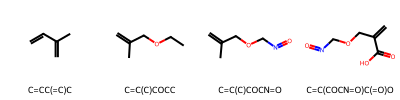

--------------------
Reaction pathway for C=C(C=CC)CC(=O)N=O:


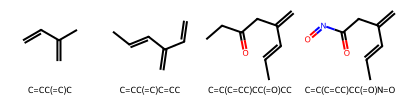

--------------------
Reaction pathway for C=C(C)C(CC(=O)OO)O[N+](=O)[O-]:


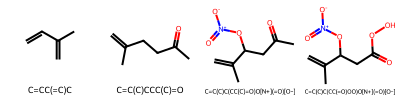

--------------------
Reaction pathway for *C(CC(=C)C)(OC)O[N+](=O)[O-]:


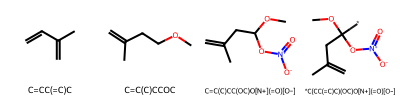

--------------------
Reaction pathway for *C(C)(C=CO[N+](=O)[O-])OCC:


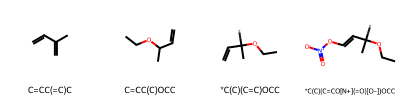

--------------------
Reaction pathway for C=C(CC(=O)CN=O)OO:


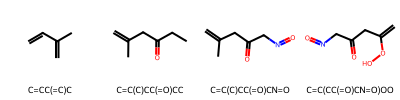

--------------------
Reaction pathway for *C(COC)C(=C)N=O:


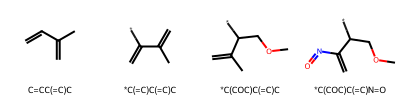

--------------------
Reaction pathway for C=CC=CC(C)C(=O)O[N+](=O)[O-]:


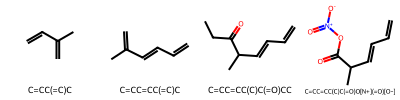

--------------------
Reaction pathway for C=CC(C[N+](=O)[O-])OO:


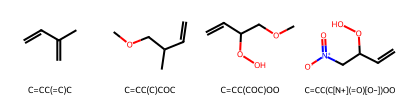

--------------------
Reaction pathway for C=C(C)C=C(C(=O)O)[N+](=O)[O-]:


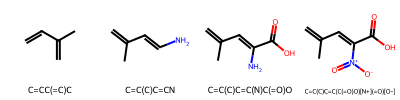

--------------------
Reaction pathway for *C(C(=C)C)C(O[N+](=O)[O-])C(C)=O:


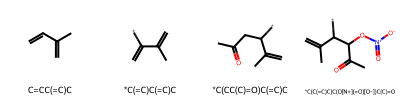

--------------------
Reaction pathway for *C(O[N+](=O)[O-])=C(C=C)C=CC:


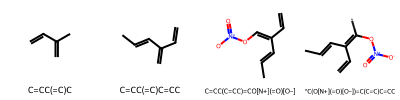

--------------------
Reaction pathway for C=CC(C=CCC(C)=O)[N+](=O)[O-]:


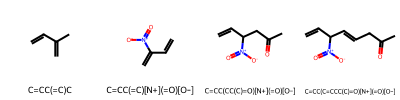

--------------------
Reaction pathway for *C(C(=C)C)=C(N)[N+](=O)[O-]:


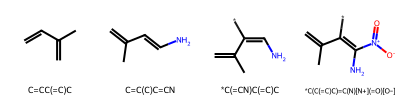

--------------------
Reaction pathway for CC(=CN=O)[N+](=O)[O-]:


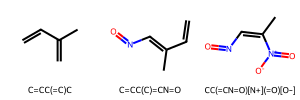

--------------------


In [ ]:
# Visualization of pathways

num_smiles_to_trace = 50

for i, product_smiles in enumerate(all_matching_smiles):
    if i >= num_smiles_to_trace:
        break

    pathway = trace_reaction_path(product_smiles, reaction_history_1)

    if pathway:
        print(f"Reaction pathway for {product_smiles}:")

        # Collect molecules
        pathway_molecules = [Chem.MolFromSmiles(pathway[0][0])]
        legends = [pathway[0][0]]

        for step in pathway:
            reactant, rxn_index, product, is_match = step
            product_mol = Chem.MolFromSmiles(product)

            if product_mol is not None and product_mol not in pathway_molecules:
                pathway_molecules.append(product_mol)
                legends.append(product)

        img = Draw.MolsToGridImage(pathway_molecules, molsPerRow=len(pathway_molecules),
                                   subImgSize=(100, 100), legends=legends, useSVG=True)
        display(img)
        print("-" * 20)